# Loan Default Prediction Model - Logistic (Logit) Regression
This notebook aims to predict loan default outcomes based on historical loan data. The approach includes data preprocessing, model training, and evaluation using a logistic regression.

### Content:

Step 1. Data Loading and Initial Setup

Step 2. Data Preprocessing

Step 3. Feature Engineering

Step 4. Logistic Model Fitting

# Step 1. Importing Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
loan=pd.read_csv('../.Database/merged_cleaned_loan.csv')
loan.set_index('id',inplace=True)

# Step 2. Variable Selection & Data Preparation

In [3]:
loan['home_ownership'].value_counts()

home_ownership
MORTGAGE    126680
RENT        109239
OWN          21638
OTHER          176
NONE            43
ANY              1
Name: count, dtype: int64

In [4]:
# As there is only 1 observation with home_ownership = ANY,
# we will drop that observation to avoid issues with regression
loan = loan.drop(loan[loan['home_ownership'] == 'ANY'].index)

In [5]:
# Drop non-numerical columns from X
X=loan.drop(columns=['addr_state','emp_title','loan_status','issue_d','issue_y','issue_m','title'])

# Drop annual_inc, to use log_annual_inc
X=X.drop(columns=['annual_inc'])

# Drop outcome variables from X
X=X.drop(columns=['loan_status_grouped','grade','sub_grade', 'int_rate'])

# Select outcome variable for Y
y=loan['loan_status_grouped']

In [6]:
#Separate numerical and categorical columns
categorical_columns = ['home_ownership', 'term','purpose','emp_length']
numerical_columns = X.select_dtypes(include=['float64']).columns

# Apply OneHotEncoding to categorical columns before splitting
# dtype=int to get binary (0 or 1) values
X_encoded = pd.get_dummies(X, columns=categorical_columns, dtype=int)

# Drop the following dummies to avoid dummy variable trap
# This ensures K-1 dummies for K groups
# Dropped dummies represent the base group
# The coefficients of the regressed dummies will be relative to the base group
X_encoded = X_encoded.drop(columns=['home_ownership_MORTGAGE','term_ 36 months','purpose_car','emp_length_0-1 years'])

# Now perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Ensure the train and test sets have the same structure (dummies already handled)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Apply scaling to numerical columns
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [7]:
# Drop rows with NaN values
X_train = X_train.dropna()
X_test = X_test.dropna()

# Ensure y_train matches X_train, y_test matches X_test
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

In [8]:
# Checking for higher collinear predictors
# vif_data = pd.DataFrame()
# vif_data["feature"] = X_train.columns
# vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
# print(vif_data)

# Step 3. Fitting Logistic Regression Model

Using statsmodels library to run Logit Regression and print results

In [9]:
# Add a constant to the independent variables
X_train_with_const = sm.add_constant(X_train)
X_test_with_const = sm.add_constant(X_test)

# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train_with_const)

# Fit the model and obtain the result object
result = logit_model.fit(maxiter=1000)

# Print the summary of the logistic regression results
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.486338
         Iterations 6
                            Logit Regression Results                           
Dep. Variable:     loan_status_grouped   No. Observations:               206220
Model:                           Logit   Df Residuals:                   206187
Method:                            MLE   Df Model:                           32
Date:                 Tue, 05 Nov 2024   Pseudo R-squ.:                 0.06580
Time:                         12:14:42   Log-Likelihood:            -1.0029e+05
converged:                        True   LL-Null:                   -1.0736e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -2.0362      0.058    -35.364   

In [10]:
# Print odds ratios in descending order
odds_ratios = np.exp(result.params)
odds_ratios = pd.Series(odds_ratios)
odds_ratios = odds_ratios.sort_values(ascending=False)
print('\nOdds Ratios\n',odds_ratios)

# Odds ratios are predicted probabilities of the effect of X variables

# odds_ratio > 1 : variable increases the probability of default
# odds_ratio < 1 : variable decreases the probability of default
# odds_ratio = 1 : variable has no effect on the probability of default

# For example, the probability of default for 'purpose_small_business' is 2.82 times
# greater than the prboability of default for 'purpose_car' (this is the base group)


Odds Ratios
 purpose_small_business          2.815074
term_ 60 months                 2.185367
purpose_medical                 1.909379
purpose_moving                  1.851894
purpose_other                   1.761820
purpose_renewable_energy        1.745906
purpose_vacation                1.707728
purpose_home_improvement        1.468827
purpose_debt_consolidation      1.364344
purpose_educational             1.359886
home_ownership_RENT             1.353943
home_ownership_OTHER            1.332450
dti                             1.313452
purpose_house                   1.303089
loan_amnt                       1.258992
purpose_credit_card             1.192164
purpose_major_purchase          1.186024
inq_last_6mths                  1.172563
home_ownership_OWN              1.125763
delinq_2yrs                     1.112356
pub_rec                         1.050558
mths_since_last_delinq          1.037055
emp_length_6-9 years            1.031291
acc_now_delinq                  1.014700
Ef

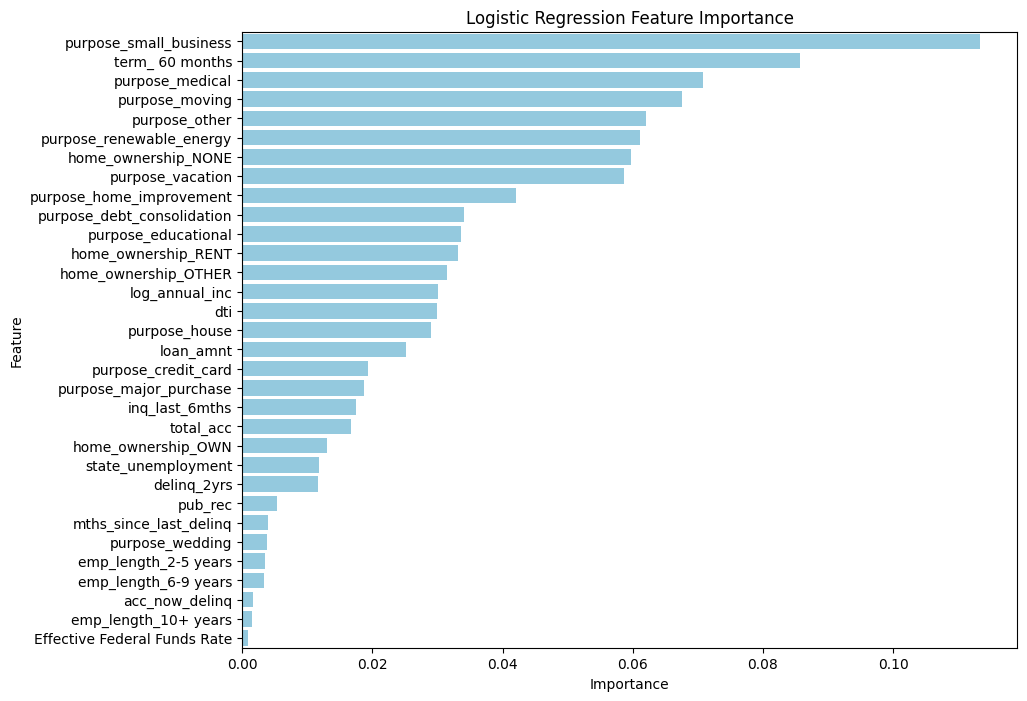

In [11]:
# Get the coefficients
coefficients = result.params

# Calculate the absolute importance values
feature_importance = np.abs(coefficients[1:])  # Exclude the intercept

# Scale the importance values by dividing by the total sum to get percentages
total_importance = feature_importance.sum()
percentage_importance = feature_importance / total_importance

# Create a DataFrame for better visualization
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': percentage_importance
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue')
plt.title('Logistic Regression Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Step 4. Making Predictions & Evaluating Model

Accuracy: 0.61 

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.59      0.70     40423
         1.0       0.31      0.67      0.42     11133

    accuracy                           0.61     51556
   macro avg       0.59      0.63      0.56     51556
weighted avg       0.75      0.61      0.64     51556



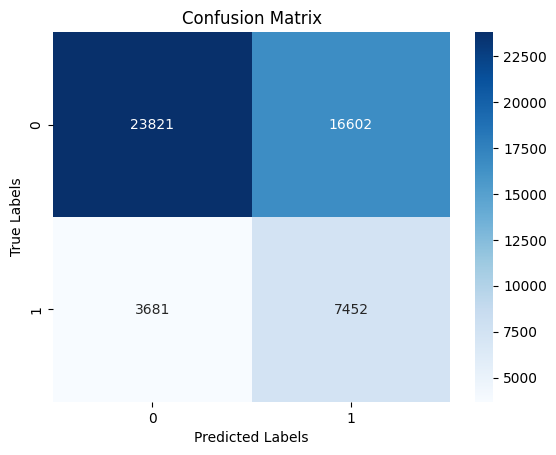

In [12]:
# Making predictions with a decision threshold
predicted_probs_test = result.predict(X_test_with_const)  
threshold = 0.2
y_pred = (predicted_probs_test >= threshold).astype(int)        

# Generating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.2f}', "\n")
print("Classification Report:\n", class_report)

# Plotting heatmap for confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=True,
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

The predictions depend on the threshold. Probabilities below the threshold are classified as 0 (repaid) and above the threshold as 1 (defaulted).
A smaller threshold will result in less false negatives (defaulted loans classified as repaid), but a fewer number of total loans.

Maximum TN/FN Ratio: 15.33 at Threshold: 0.06


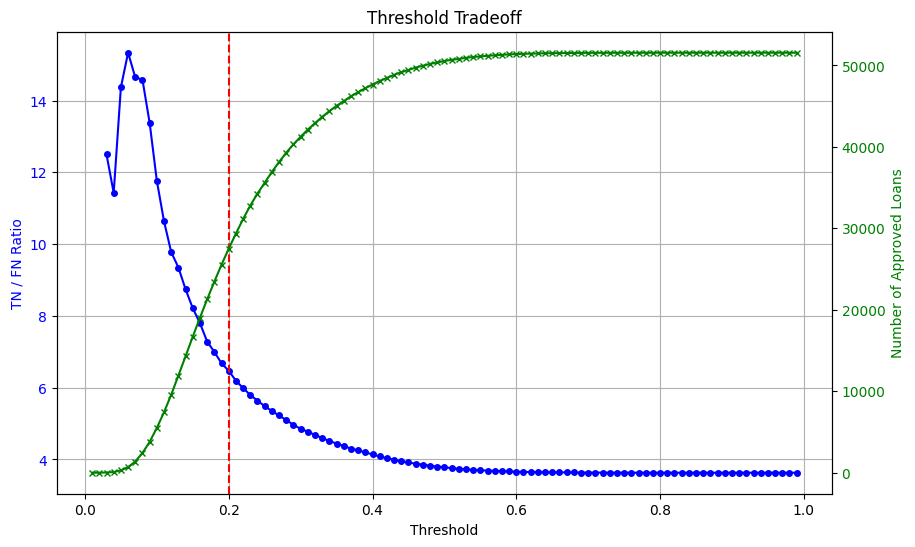

In [13]:
# Plotting True Negatives (TN) / False Negatives (FN) and number of approved loans against the threshold,

predicted_probs_test = result.predict(X_test_with_const)

ratios = []
approved_loans = []
thresholds = np.arange(0.01, 1.00, 0.01)

for threshold in thresholds:
    y_pred = (predicted_probs_test >= threshold).astype(int)
    TN = np.sum((y_pred == 0) & (y_test == 0))
    FN = np.sum((y_pred == 0) & (y_test == 1))
    
    if FN > 0:
        ratio = TN / FN
    else:
        ratio = np.nan 

    ratios.append(ratio)
    approved_loans.append(TN + FN)

# Filter out infinite and NaN ratios
valid_ratios = [(ratio, threshold) for ratio, threshold in zip(ratios, thresholds) if pd.notna(ratio) and ratio != np.inf]

# Find the maximum ratio and its corresponding threshold
if valid_ratios:
    max_ratio, best_threshold = max(valid_ratios, key=lambda x: x[0])

    # Print the threshold that gives the maximum ratio
    print(f'Maximum TN/FN Ratio: {max_ratio:.2f} at Threshold: {best_threshold:.2f}')
else:
    print("No valid ratios found.")

# Plotting the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the TN/FN ratio on the primary y-axis
ax1.plot(thresholds, ratios, marker='o', markersize=4, color='b', label='TN / FN Ratio')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('TN / FN Ratio', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid()

# Create a secondary y-axis to plot the number of approved loans
ax2 = ax1.twinx()
ax2.plot(thresholds, approved_loans, marker='x', markersize=4, color='g', label='Number of Approved Loans')
ax2.set_ylabel('Number of Approved Loans', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Set limits for the y-axes
try:
    max_ratio_limit = max(filter(lambda x: x != np.inf, ratios), default=0)
    ax1.set_ylim(0, max_ratio_limit * 1.1)

    max_approved_loans_limit = max(approved_loans, default=0)
    ax2.set_ylim(0, max_approved_loans_limit * 1.1)
except ValueError:
    pass

# Plotting a vertical line at threshold = 0.2
ax1.axvline(x=0.2, color='r', linestyle='--', label='Threshold = 0.2')

plt.title('Threshold Tradeoff')

plt.show()


In [14]:
# Create DataFrame
logit_results = pd.DataFrame({
    "Threshold": thresholds,
    "Ratio": ratios,
    "Approved Loan": approved_loans
})

# Export to CSV
logit_results.to_csv("../.systemfiles/logit_results.csv", index=False)

In [15]:
# Making predictions for both X test and X train  
predicted_probs_test = result.predict(X_test_with_const)
X_test_with_const['predicted_probs'] = predicted_probs_test

predicted_probs_train = result.predict(X_train_with_const)
X_train_with_const['predicted_probs'] = predicted_probs_train

X_combined = pd.concat([X_test_with_const, X_train_with_const], axis=0)

In [16]:
X_combined

,const,delinq_2yrs,dti,inq_last_6mths,loan_amnt,mths_since_last_delinq,pub_rec,total_acc,acc_now_delinq,log_annual_inc,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,emp_length_10+ years,emp_length_2-5 years,emp_length_6-9 years,predicted_probs
id,,,,,,,,,,,,,,,,,,,,,
387539,1.0,-0.338807,-1.450360,6.146282,-1.495947,-0.689396,-0.324767,0.077673,-0.052444,-2.884386,...,0,1,0,0,0,0,1,0,0,0.408992
12527917,1.0,0.973035,0.340166,0.961526,-0.457046,0.236059,-0.324767,0.840364,-0.052444,1.670306,...,0,0,0,0,0,0,0,1,0,0.112497
883654,1.0,-0.338807,-0.075195,-0.766726,-1.068164,-0.689396,-0.324767,2.365746,-0.052444,-0.055426,...,0,0,0,0,0,0,1,0,0,0.066692
15309561,1.0,0.973035,-1.541100,0.097400,-0.563992,0.015713,-0.324767,0.331903,-0.052444,0.916996,...,0,0,0,1,0,0,0,1,0,0.182540
40959969,1.0,-0.338807,-0.387036,-0.766726,0.276296,-0.689396,-0.324767,-1.193479,-0.052444,-0.398991,...,0,0,0,0,0,0,1,0,0,0.206471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679904,1.0,-0.338807,0.645616,-0.766726,-0.594548,1.381861,-0.324767,-0.261301,-0.052444,-0.515062,...,0,0,0,0,0,0,0,1,0,0.166429
3217964,1.0,-0.338807,-0.881635,0.961526,-0.273711,-0.689396,-0.324767,-0.939248,-0.052444,0.514360,...,0,1,0,0,0,0,0,1,0,0.178875
1482608,1.0,-0.338807,0.038550,-0.766726,-0.457046,1.117445,-0.324767,-0.091814,-0.052444,-1.539609,...,0,0,0,0,0,0,0,0,1,0.223420


In [17]:
# X_combined.to_csv('..\.Database\logit_predictions.csv', index=True)